In [1]:
import pandas as pd
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

In [2]:
stk_data=pd.read_csv("Tatacoffee13_21.csv")

In [3]:
df=stk_data[["Open","High","Low","Close"]]

In [4]:
#Check for Stationarity

In [5]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] > 0.05:
        print("Series is Non-Stationary\n")
    else:
        print("Series is Stationary\n")

In [6]:
# --- Check stationarity for each column ---
stationary_cols = {}
for col in df.columns:
    print(f'-- {col} --')
    stationary_cols[col] = adf_test(df[col])

-- Open --
ADF Statistic: -2.502734388619978
p-value: 0.11481043527381063
Series is Non-Stationary

-- High --
ADF Statistic: -2.4624806524241962
p-value: 0.12487205548565944
Series is Non-Stationary

-- Low --
ADF Statistic: -3.0552958774686485
p-value: 0.030043294422663944
Series is Stationary

-- Close --
ADF Statistic: -3.007236327367315
p-value: 0.03422412229093029
Series is Stationary



In [7]:
# --- Difference non-stationary columns ---
df_diff = df.copy()
diff_cols = []  # define here
for col, is_stationary in stationary_cols.items():
    if not is_stationary:
        df_diff[col] = df[col].diff()
        diff_cols.append(col)
        df_diff = df_diff.dropna()


In [8]:
#for col in df_diff.columns:
 #   print(f'-- {col} --')
  #  adf_test(df_diff[col])

In [9]:
# --- Train-Test Split ---
test_obs = 28
train = df_diff[:-test_obs]
test = df_diff[-test_obs:]


In [10]:
# --- Fit VAR model ---
from statsmodels.tsa.api import VAR  
model = VAR(train)
results = model.fit(maxlags=12, ic='aic')  # best lag via AIC
print(f"\nSelected Lag Order: {results.k_ar}\n")
print(results.summary())



Selected Lag Order: 12

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 21, Oct, 2025
Time:                     15:12:07
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    17.6185
Nobs:                     2184.00    HQIC:                   17.2946
Log likelihood:          -30881.8    FPE:                2.69102e+07
AIC:                      17.1080    Det(Omega_mle):     2.46248e+07
--------------------------------------------------------------------
Results for equation Open
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const            -0.511203         0.427407           -1.196           0.232
L1.Open          -0.783756         0.079979           -9.800           0.000
L1.High          -0.719150         0.089760         

C:\Anaconda3\envs\ts_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [11]:
# --- Forecast ---
lag_order = results.k_ar
forecast_input = train.values[-lag_order:]
forecast = results.forecast(y=forecast_input, steps=test_obs)
forecast_df = pd.DataFrame(forecast, index=test.index, columns=test.columns)
print("\nForecasted values:")
print(forecast_df)



Forecasted values:
          Open      High       Low     Close
2197  2.450334  1.605841 -1.481413 -0.294696
2198 -2.651765 -1.517001 -1.378848 -1.198303
2199  0.205818 -0.454135  0.386531  0.221878
2200  0.174590 -0.418003 -0.414366 -0.742247
2201 -0.796352 -1.729045 -1.253900 -1.748921
2202 -0.648896  0.490079 -0.873266 -0.518470
2203 -2.169309 -1.544305 -0.622549 -0.624735
2204  0.138845 -0.099079  0.281895  0.071565
2205 -0.523999 -1.126328 -0.740287 -1.013162
2206 -0.247598 -0.240585 -0.493882 -0.172335
2207 -0.620316 -1.062317 -0.860781 -1.443492
2208 -1.018064 -0.650128 -1.352657 -0.614441
2209 -1.173371 -1.018518 -0.885912 -1.045250
2210 -0.798714 -0.582857 -0.787796 -0.503182
2211 -0.498511 -0.221401 -0.141026 -0.194788
2212 -0.060649 -0.480024 -0.161694 -0.377999
2213 -0.223386 -0.458745 -0.407052 -0.518550
2214 -0.636337 -0.746218 -0.748490 -0.722490
2215 -0.868348 -0.604600 -0.825301 -0.700105
2216 -0.787802 -0.821807 -0.607377 -0.688480
2217 -0.670042 -0.648353 -0.706610 

In [12]:
# --- Revert differencing for non-stationary columns ---
forecast_original = forecast_df.copy()
for col in diff_cols:
    last_train_value = df[col].iloc[len(train)-1]  # last original value before forecast
    forecast_original[col] = forecast_df[col].cumsum() + last_train_value
print("\nForecasted values in original scale:")
print(forecast_original)



Forecasted values in original scale:
            Open        High         Low       Close
2197  229.850334  230.605841  221.768587  224.505304
2198  227.198569  229.088839  220.389739  223.307001
2199  227.404387  228.634705  220.776270  223.528879
2200  227.578977  228.216701  220.361904  222.786632
2201  226.782625  226.487657  219.108004  221.037711
2202  226.133729  226.977736  218.234738  220.519241
2203  223.964420  225.433431  217.612190  219.894506
2204  224.103266  225.334352  217.894085  219.966071
2205  223.579267  224.208024  217.153798  218.952909
2206  223.331668  223.967439  216.659916  218.780574
2207  222.711352  222.905122  215.799134  217.337082
2208  221.693289  222.254995  214.446477  216.722641
2209  220.519918  221.236477  213.560565  215.677390
2210  219.721204  220.653620  212.772769  215.174208
2211  219.222693  220.432219  212.631743  214.979420
2212  219.162045  219.952195  212.470050  214.601421
2213  218.938658  219.493450  212.062998  214.082871
2214  21

In [14]:
#evaluate
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(test[col], forecast_df[col])
rmse = np.sqrt(mse)
print("\nEvaluation Metrics:")
for col in df_diff.columns:
    mse = mean_squared_error(test[col], forecast_df[col])
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(test[col], forecast_df[col])
    print(f"{col} -> RMSE: {rmse:.4f}, MAPE: {mape:.4f}")




Evaluation Metrics:
Open -> RMSE: 6.1770, MAPE: 1.2888
High -> RMSE: 5.1558, MAPE: 0.9310
Low -> RMSE: 6.3111, MAPE: 1.3445
Close -> RMSE: 5.8027, MAPE: 1.5147


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot one column using Seaborn
def plot_forecast_seaborn(col_name, actual_df, forecast_df, test_obs=28):
    # Prepare DataFrame in long format for Seaborn
    plot_df = pd.DataFrame({
        'Time': list(actual_df.index[-test_obs:]) + list(forecast_df.index),
        'Value': list(actual_df[col_name].iloc[-test_obs:]) + list(forecast_df[col_name]),
        'Type': ['Actual']*test_obs + ['Forecast']*len(forecast_df)
    })

    plt.figure(figsize=(10,5))
    sns.lineplot(data=plot_df, x='Time', y='Value', hue='Type', lw=2)
    plt.title(f"{col_name} - Actual vs Forecast (Seaborn)")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.show()


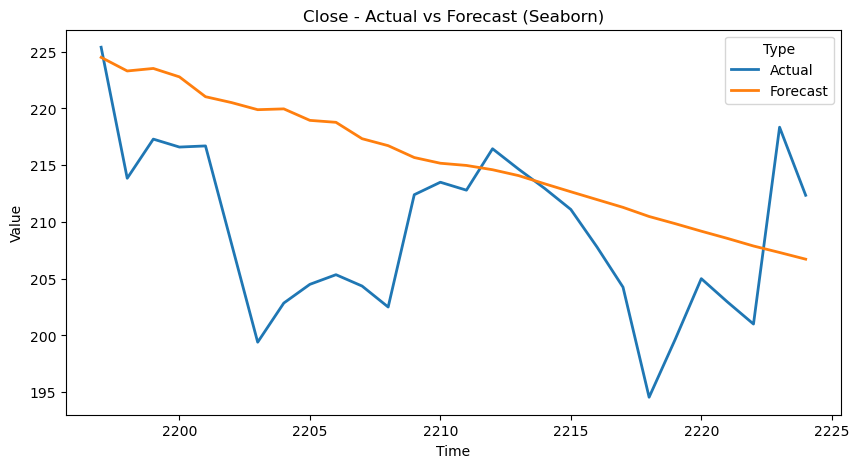

In [17]:
# Plot Close column
plot_forecast_seaborn("Close", df, forecast_original)